# Configuration

Set the values in this cell, then just run the notebook. More advanced configuration options are specified in the text blocks below.

Note that directory paths can't use `~/...` for some reason, either they have to be full or relative.

In [17]:
EVAL_NAME = 'doubles_step_11-10'
WEIGHTS = '6.0-2.0-2.0'
MEMORY = True
PLACE_IN_PAPER = False

EVAL_DIR = '/home/trevor/Projects/maki/evaluations/'
PAPER_FIGURES_DIR = '/home/trevor/Projects/maki/misc/ndn-mab/figures/'

# Setup

In [10]:
import numpy as np
import seaborn as sb
import pandas as pd
import os
import pickle
from __future__ import unicode_literals
%matplotlib inline

### Create or Load Data

Run the first cell if you haven't visualized this data yet, run the second cell if you have. The first cell creates and saves the DataFrame, the second cell loads it.

In [19]:
SEG_LENGTH = 2 # seconds
BANDIT_ALGOS = ['sbu', 'sbusvi', 'sbuose', 'linucb']

# Collect the data
def parseStats(raw_log, num_blocks, is_bandit):
    lines = [l.strip() for l in raw_log.splitlines()]
    stat_blocks = [{}]
    for l in lines:
        if 'stat-begin' in l:
            stat_blocks.append({})
            timestamp = prev_line.split()[0]
            stat_blocks[-1]['timestamp'] = timestamp
        # LinUCB has an extra stat called "stat-bandit-normal"
        elif 'stat-' in l and not 'stat-nonbandit' in l and not 'stat-bandit-normal' in l:
            l_split = l.split()
            key = l_split[-2]
            val = l_split[-1]
            stat_blocks[-1][key] = val
        # Get the timestamp for the block
        if (is_bandit and 'stat-qual' in l) or (not is_bandit and 'stat-begin' in l):
            timestamp = prev_line.split()[0]
            stat_blocks[-1]['timestamp'] = timestamp
        # Fill in the first choose-exec-ms for bandits
        if is_bandit and len(stat_blocks) == 1:
            stat_blocks[-1]['stat-chexecms'] = 0
        prev_line = l
    # Trim excess
    return stat_blocks[:num_blocks]

# DF columns:
# algo
# segNum
# epoch
# qual
# choose-exec-ms
# buffer-pct
# base-qoe
# decline-qoe
# rebuff-ms-qoe
# segment-qoe
# cumul-qoe
# update-exec-ms
# client
df_dict = {
    'algo': [],
    'seg-num': [],
    'epoch': [],
    'quality-lvl': [],
    'choose-exec-ms': [],
    'memory': [],
    'weights': [],
    'base-qoe': [],
    'decline-qoe': [],
    'rebuff-ms-qoe': [],
    'segment-qoe': [],
    'cumul-qoe': [],
    'update-exec-ms': [],
    'client': [],
    'num-segments': [],
    'topology': [],
    'timestamp': []
}
for root, subdirs, files in os.walk(EVAL_DIR+'{}/results'.format(EVAL_NAME)):
    for filename in files:
        # Ignore hidden/swap files, etc.
        if filename.startswith('.'):
            continue
        with open(root+'/'+filename, 'r') as f:
            # Filename convention: algo_topo_length_w1-w2-w3_memory_client_epoch
            filename_parts = filename.split('_')
            num_segments = int(int(filename_parts[2]) / SEG_LENGTH)
            is_bandit = filename_parts[0] in BANDIT_ALGOS
            is_mem = filename_parts[4] == 'memory'
            stats = parseStats(f.read(), num_segments, is_bandit)
            for i, segment_stats in enumerate(stats):
                essential_stats = ['stat-qual', 'stat-qoebase', 'stat-qoedecl', 'stat-qoerebuffms', 
                                   'stat-qoeseg', 'stat-qoecum']
                # Not a complete block; ignore it
                if not set(essential_stats).issubset(list(segment_stats.keys())):
                    continue
                # Make an additional check for bandits.
                # We need to check this one because it comes after the other essentials, but not chexecms
                # because that one comes before.
                if is_bandit and not 'stat-updexecms' in list(segment_stats.keys()):
                    continue
                # Check if segment is bandit
                if is_bandit:
                    df_dict['choose-exec-ms'].insert(0, segment_stats['stat-chexecms'])
                    df_dict['update-exec-ms'].insert(0, segment_stats['stat-updexecms'])
                else:
                    df_dict['choose-exec-ms'].insert(0, 0)
                    df_dict['update-exec-ms'].insert(0, 0)
                # Common regardless of algo
                df_dict['seg-num'].insert(0, i+1)
                df_dict['algo'].insert(0, filename_parts[0])
                df_dict['client'].insert(0, filename_parts[-2])
                df_dict['epoch'].insert(0, filename_parts[-1])
                df_dict['num-segments'].insert(0, num_segments)
                df_dict['topology'].insert(0, filename_parts[1])
                df_dict['weights'].insert(0, filename_parts[3])
                df_dict['memory'].insert(0, is_mem)
                df_dict['quality-lvl'].insert(0, segment_stats['stat-qual'])
                df_dict['base-qoe'].insert(0, segment_stats['stat-qoebase'])
                df_dict['decline-qoe'].insert(0, segment_stats['stat-qoedecl'])
                df_dict['rebuff-ms-qoe'].insert(0, segment_stats['stat-qoerebuffms'])
                df_dict['segment-qoe'].insert(0, segment_stats['stat-qoeseg'])
                df_dict['cumul-qoe'].insert(0, segment_stats['stat-qoecum'])
                df_dict['timestamp'].insert(0, segment_stats['timestamp'])
                
df = pd.DataFrame(data=df_dict)
df[
    ['seg-num',
    'epoch',
    'quality-lvl',
    'base-qoe',
    'decline-qoe',
    'rebuff-ms-qoe',
    'segment-qoe',
    'cumul-qoe',
    'choose-exec-ms',
    'update-exec-ms',
    'num-segments',
    'timestamp']] = df[
    ['seg-num',
    'epoch',
    'quality-lvl',
    'base-qoe',
    'decline-qoe',
    'rebuff-ms-qoe',
    'segment-qoe',
    'cumul-qoe',
    'choose-exec-ms',
    'update-exec-ms',
    'num-segments',
    'timestamp']].apply(pd.to_numeric)
mem_str = lambda x: 'memory' if x else 'no-memory'
df['algo-client-weights-mem'] = df['algo']+'-'+df['client']+'-'+df['weights']+'-'+df['memory'].apply(mem_str)
df['elapsed-s'] = df.groupby(
    by=['algo', 'client', 'topology', 'epoch', 'weights', 'memory'])['timestamp'].transform(
    lambda t: t-t.min())
orig_df = df.copy(deep=True)

with open(EVAL_DIR+'{}/df.pkl'.format(EVAL_NAME), 'wb') as f:
    pickle.dump(orig_df, f)

In [20]:
with open(EVAL_DIR+'{}/df.pkl'.format(EVAL_NAME), 'rb') as f:
    orig_df = pickle.load(f)

### IEEE Spec

This keeps the figures within the IEEE specifications. If you want to temporarily increase the figure size to make it easier to interpret, multiply `fig_width` by a scalar, e.g. `fig_width *= 2`.

In [21]:
# For presentation
import matplotlib as mpl
import figure_configuration_ieee_standard as ieee_config
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

import numpy as np
import matplotlib.pyplot as plt

ieee_config.figure_configuration_ieee_standard()

k_scaling = 2
    # scaling factor of the figure
    # (You need to plot a figure which has a width of (8.8 * k_scaling)
    # in MATLAB, so that when you paste it into your paper, the width will be
    # scalled down to 8.8 cm  which can guarantee a preferred clearness.

k_width_height = 1.5#1.3  # width:height ratio of the figure

fig_width = 8.8/2.54 * k_scaling
fig_height = fig_width / k_width_height

params = {'figure.figsize': [fig_width, fig_height],
         'axes.labelsize': 8*k_scaling,  # fontsize for x and y labels (was 10)
              'axes.titlesize': 8*k_scaling,
              'font.size': 8*k_scaling,  # was 10
              'legend.fontsize': 8*k_scaling,  # was 10
              'xtick.labelsize': 8*k_scaling,
              'ytick.labelsize': 8*k_scaling,
              'xtick.major.width': 1*k_scaling,
              'xtick.major.size': 3.5*k_scaling,
              'ytick.major.width': 1*k_scaling,
              'ytick.major.size': 3.5*k_scaling,
              'lines.linewidth': 2.5*k_scaling,
              'axes.linewidth': 1*k_scaling,
              'axes.grid': True,
              'savefig.format': 'pdf',
              'axes.xmargin': 0,
              'axes.ymargin': 0,
              'savefig.pad_inches': 0,
              'legend.markerscale': 1*k_scaling,
              'savefig.bbox': 'tight',
              'lines.markersize': 2*k_scaling,
              'legend.numpoints': 4*k_scaling,
              'legend.handlelength': 3.5*k_scaling,
         }
import matplotlib
matplotlib.rcParams.update(params)

#paper_rc = {'lines.linewidth': 1, 'lines.markersize': 1}
#sb.set_context('paper', rc=paper_rc)

### Filter

Currently only plot the results from client1. You can change this to do a different client or multiple clients.

In [42]:
# Filter unwanted runs
df = orig_df
df = df.loc[(df['client']=='client1')]

if WEIGHTS:
    df = df.loc[df['weights']==WEIGHTS]

if MEMORY:
    df = df.loc[(df['memory']==True) | (df['algo']=='bola') | (df['algo']=='p')]
else:
    df = df.loc[df['memory']==False]
    
# For filenames
if MEMORY:
    m_str = 'mem'
else:
    m_str = 'no-mem'
suffix = '_{}_{}'.format(WEIGHTS, m_str)

# Sort, just to be safe
df = df.sort_values(by=['algo-client-weights-mem', 'seg-num'], ascending=True)

In [32]:
import csv

ALGO_ORDER = [
    'sbuose',
    'sbu',
    'linucb',
    'p',
    'bola'
]
algo_dtype = pd.api.types.CategoricalDtype(categories=ALGO_ORDER, ordered=True)

class AlgoStyle:    
    def __init__(self, name, color, linestyle='None', markerstyle='None', markersize=7):
        self.name = name
        self.color = color
        self.linestyle = linestyle
        self.markerstyle = markerstyle
        self.markersize = markersize

styles = {
    'bola': AlgoStyle('BOLA', 'tab:red', linestyle='--'),
    'p': AlgoStyle('PANDA', 'tab:blue', linestyle='-'),
    'sbu': AlgoStyle('CBA-VB', 'tab:green', linestyle=':'),
    'sbuose': AlgoStyle('CBA-OS-SVI', 'tab:green', linestyle='-.'),
    'linucb': AlgoStyle('LinUCB', 'tab:orange', markerstyle='^'),
    'bandwidth': AlgoStyle('Bandwidth', 'tab:blue', linestyle='-')
}

df['algo-cat'] = df['algo'].astype(algo_dtype)


### Bandwidth Stuff

Note the file name in the `open(...` function. If your traces have a different naming scheme or something, you should change this so it loads the right trace.

In [33]:
def get_bw_df(first_epoch=1, last_epoch=30):
    bw_df_dict = {
    'epoch': [],
    'time': [],
    'bandwidth': []
    }
    for epoch in range(first_epoch, last_epoch+1):
        bw_trace_list = []
        with open(EVAL_DIR+'{}/bandwidth_traces/client1_epoch{}.csv'.format(EVAL_NAME, epoch), 'r') as f:
            reader = csv.reader(f, delimiter=',')
            total_s = 0
            for row in reader:
                bandwidth = float(row[0])*1000
                total_s += float(row[1])
                bw_df_dict['epoch'].append(epoch)
                bw_df_dict['time'].append(total_s)
                bw_df_dict['bandwidth'].append(bandwidth)
                if total_s >= 220:
                    break
    bandwidth_df = pd.DataFrame(bw_df_dict)
    return bandwidth_df

def get_bw_intvl_df(bandwidth_df, period_len=1.0):
    bw_stddev_df_dict = {
        'time-group': [],
        'avg-bw': [],
        'std-dev': []
    }
    bw_time_cut = pd.cut(bandwidth_df['time'], np.arange(0, 220.0, period_len))
    for group, group_df in bandwidth_df.groupby(bw_time_cut):
        avg_bw = group_df['bandwidth'].mean()
        std_dev = group_df['bandwidth'].std()
        bw_stddev_df_dict['time-group'].append(group)
        bw_stddev_df_dict['avg-bw'].append(avg_bw)
        bw_stddev_df_dict['std-dev'].append(std_dev)
    bw_stddev_df = pd.DataFrame(bw_stddev_df_dict)
    bw_stddev_df['time-group-id'] = bw_stddev_df['time-group'].astype('category').cat.codes
    bw_stddev_df['elapsed-s'] = bw_stddev_df['time-group-id']*period_len
    bw_stddev_df['avg-bw-mbps'] = bw_stddev_df['avg-bw'] / 1000
    return bw_stddev_df

# Visualizations

These are the 5 main visualizations. Just run them in sequence to produce the images.

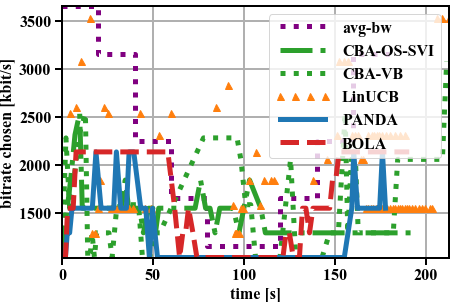

In [34]:
# Bitrate chosen vs. playback time

ax = plt.gca()

# Plot bandwidth
# This is the mean per segment across all available epochs
bw_df = get_bw_df(last_epoch=df['epoch'].max())
bw_intvl_df = get_bw_intvl_df(bw_df, 20.0)
ax.step(bw_intvl_df['elapsed-s'], bw_intvl_df['avg-bw'], color='purple',
        linewidth=5, linestyle=':', where='post')

# Plot bitrates
# This is the mean per segment across all available epochs
for group_name, group_df in df.groupby(['algo-cat']):
    algo = group_name.split('-')[0]
    mean_df = group_df.groupby(by=['seg-num']).mean()
    ax.plot(mean_df['elapsed-s'], 
            mean_df['base-qoe'], 
            label=styles[algo].name, 
            linestyle=styles[algo].linestyle,
            marker=styles[algo].markerstyle, 
            markersize=styles[algo].markersize, 
            color=styles[algo].color)

# Cosmetic
ax.set(xlabel='time [s]', ylabel='bitrate chosen [kbit/s]')
ax.grid(linewidth=k_scaling)
lgnd = ax.legend(loc='upper right', handlelength=3.4, numpoints=4)
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(7)
    
# Save it to the paper
if PLACE_IN_PAPER:
    plt.savefig(PAPER_FIGURES_DIR+'bitrate_playback'+suffix+'.pdf')

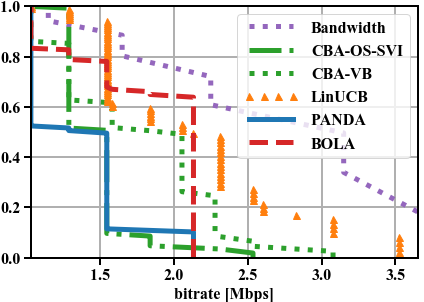

In [35]:
# CDF of bitrate chosen

ax = plt.gca()

# Plot bandwidth trace
dx = 0.01
bw_df = get_bw_df(last_epoch=df['epoch'].max())
bw_intvl_df = get_bw_intvl_df(bw_df, 20.0)
X = np.array(sorted(bw_intvl_df['avg-bw-mbps'], reverse=True))
X = X[:-1]
Y = np.copy(X)
Y /= (dx*Y).sum()
CY = np.cumsum(Y*dx)
plt.plot(X, CY, label='Bandwidth', color='tab:purple', linestyle=':')

# Plot algo traces
for group, group_df in df.groupby(['algo-cat']):
    algo = group.split('-')[0]
    group_df = group_df.groupby(['seg-num']).mean()
    group_df['base-qoe-mbps'] = group_df['base-qoe']/1000
    sorted_df = group_df.sort_values(by=['base-qoe-mbps'], 
                                     ascending=False)
    Y = sorted_df['base-qoe-mbps'].copy(deep=True)
    Y /= abs(dx*Y).sum()
    CY = np.cumsum(abs(Y*dx)).tolist()
    x_axis = sorted_df['base-qoe-mbps'].tolist()
    x_axis.insert(0, x_axis[0])
    CY.insert(0, 0)
    ax.plot(x_axis, 
            CY, 
            label=styles[algo].name, 
            linestyle=styles[algo].linestyle,
            marker=styles[algo].markerstyle, 
            markersize=styles[algo].markersize, 
            color=styles[algo].color)

# Cosmetic
ax.set(xlabel='bitrate [Mbps]', ylim=(0, 1))
ax.grid(linewidth=k_scaling)
lgnd = ax.legend(loc='upper right', handlelength=3.4, numpoints=4)
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(7)

# Save to paper
if PLACE_IN_PAPER:
    plt.savefig(PAPER_FIGURES_DIR+'bitrate_cdf'+suffix+'.pdf')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: 'seg-num' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


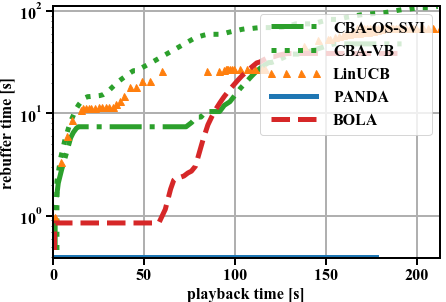

In [36]:
ax = plt.gca()

# Plot the rebuffer times
for group_name, group_df in df.groupby(['algo-cat']):
    algo = group_name.split('-')[0]
    mean_df = group_df.groupby(by=['seg-num']).mean()
    mean_df['seg-num'] = mean_df.index
    mean_df['rebuff-ms-cumsum'] = mean_df.sort_values(
        by=['seg-num'], ascending=True)['rebuff-ms-qoe'].transform(
        pd.Series.cumsum)
    mean_df['rebuff-s-cumsum'] = mean_df['rebuff-ms-cumsum']/1000
    mean_df = mean_df.sort_values(by=['elapsed-s'], ascending=True)
    ax.plot(mean_df['elapsed-s'], 
            mean_df['rebuff-s-cumsum'], 
            label=styles[algo].name, 
            linestyle=styles[algo].linestyle,
            marker=styles[algo].markerstyle, 
            markersize=styles[algo].markersize, 
            color=styles[algo].color)


# Set the scale
ax.set(yscale='log')

# Cosmetic
ax.set(xlabel='playback time [s]', ylabel='rebuffer time [s]')
ax.grid(linewidth=k_scaling)
lgnd = ax.legend(loc='upper right', handlelength=3.4, numpoints=4)
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(7)

# Save to paper
if PLACE_IN_PAPER:
    plt.savefig(PAPER_FIGURES_DIR+'new_rebuff_s_log'+suffix+'.pdf')

In [37]:
# Create a new DataFrame for the next 2 visualizations
switch_df_dict = {
    'algo': [],
    'epoch': [],
    'switches': [],
    'magnitude': []
}
for group, group_df in df.groupby(['algo']):
    num_switch_list = []
    mag_switch_list = []
    for epoch, epoch_df in group_df.groupby(['epoch']):
        prev_qual = -1
        num_switches = 0
        total_magnitude = 0
        epoch_df['base-qoe-mbps'] = epoch_df['base-qoe'] / 1000
        for qual in epoch_df['base-qoe-mbps']:
            if prev_qual == -1:
                prev_qual = qual
            elif prev_qual != qual:
                num_switches += 1
                total_magnitude += abs(prev_qual - qual)
                prev_qual = qual
        switch_df_dict['algo'].insert(0, group)
        switch_df_dict['epoch'].insert(0, epoch)
        switch_df_dict['switches'].insert(0, num_switches)
        if num_switches > 0:
            switch_df_dict['magnitude'].insert(0, (total_magnitude / num_switches))
        else:
            switch_df_dict['magnitude'].insert(0, 0)
switch_df = pd.DataFrame(switch_df_dict)
switch_df['algo-cat'] = switch_df['algo'].astype(algo_dtype)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


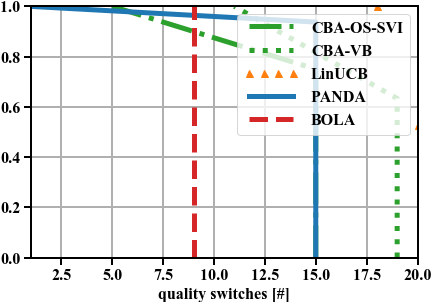

In [38]:
# CDF of number of switches

ax = plt.gca()

# Plot algo traces
for group, group_df in switch_df.groupby(['algo-cat']):
    algo = group.split('-')[0]
    mean_df = group_df.groupby(['epoch']).mean()
    mean_df = mean_df.sort_values(by=['switches'], ascending=False)
    Y = mean_df['switches'].copy(deep=True)
    Y /= abs(dx*Y).sum()
    CY = np.cumsum(abs(Y*dx)).tolist()
    x_axis = mean_df['switches'].tolist()
    x_axis.insert(0, x_axis[0])
    CY.insert(0, 0)
    ax.plot(x_axis, 
            CY, 
            label=styles[algo].name, 
            linestyle=styles[algo].linestyle,
            marker=styles[algo].markerstyle, 
            markersize=styles[algo].markersize, 
            color=styles[algo].color)

# Cosmetic
ax.set(xlabel='quality switches [#]')
ax.grid(linewidth=k_scaling)
lgnd = ax.legend(loc='upper right', handlelength=3.4, numpoints=4)
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(7)

# Save to paper
if PLACE_IN_PAPER:
    plt.savefig(PAPER_FIGURES_DIR+'qual_switch_cdf'+suffix+'.pdf')

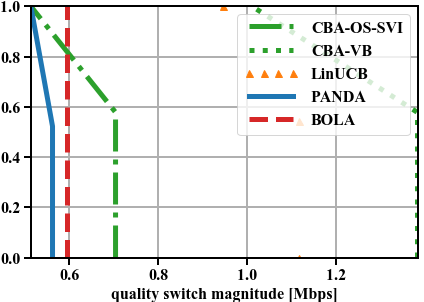

In [39]:
# CDF of switch magnitude

ax = plt.gca()

# Plot algo traces
for group, group_df in switch_df.groupby(['algo-cat']):
    algo = group.split('-')[0]
    mean_df = group_df.groupby(['epoch']).mean()
    mean_df = mean_df.sort_values(by=['magnitude'], ascending=False)
    Y = mean_df['magnitude'].copy(deep=True)
    Y /= abs(dx*Y).sum()
    CY = np.cumsum(abs(Y*dx)).tolist()
    x_axis = mean_df['magnitude'].tolist()
    x_axis.insert(0, x_axis[0])
    CY.insert(0, 0)
    ax.plot(x_axis, 
            CY, 
            label=styles[algo].name, 
            linestyle=styles[algo].linestyle,
            marker=styles[algo].markerstyle, 
            markersize=styles[algo].markersize, 
            color=styles[algo].color)

# Cosmetic
ax.set(xlabel='quality switch magnitude [Mbps]', ylim=(0,1))
ax.grid(linewidth=k_scaling)
lgnd = ax.legend(loc='upper right', handlelength=3.4, numpoints=4)
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(7)

# Save to paper
if PLACE_IN_PAPER:
    plt.savefig(PAPER_FIGURES_DIR+'switch_magnitude_cdf'+suffix+'.pdf')

# Miscellaneous

These are things that rely on the DataFrame, but aren't related to the above visualizations.

### Fairness Data

This is used to create the fairness visualization. Note that you **have** to comment out the line in the filter cell where we limit ourselves to 1 client, as otherwise the array for client2 will be empty.

Comment that line, then run the filter cell, then skip down here and run this cell.

In [41]:
# Output the data for Bastian's fairness code
# Remove any periods to avoid problems rendering the pictures
fairness_suffix = suffix.replace('.', '')
for client in ['client1', 'client2']:
    for algo in ['sbu', 'sbuose', 'linucb', 'bola', 'p']:
        X = df.loc[df['algo']==algo].loc[
                df['client']==client].sort_values(
                by='seg-num', ascending=True).groupby('seg-num').mean().filter(
                items=['elapsed-s', 'segment-qoe']).values
        with open(algo+'_'+client+fairness_suffix+'.npy', 'wb') as f:
            np.save(f, X)

### Table Statistics

We have some tables in the paper, here's how you get their values.

In [43]:
# Table statistics
for group, group_df in df.groupby(['algo-client-weights-mem']):
    mean_df = group_df.groupby(by=['seg-num']).mean()
    # Calculate quality switches
    num_switch_list = []
    mag_switch_list = []
    for epoch, epoch_df in group_df.groupby(['epoch']):
        prev_qual = -1
        num_switches = 0
        total_magnitude = 0
        epoch_df['base-qoe-mbps'] = epoch_df['base-qoe'] / 1000
        for qual in epoch_df['base-qoe-mbps']:
            if prev_qual == -1:
                prev_qual = qual
            elif prev_qual != qual:
                num_switches += 1
                total_magnitude += abs(prev_qual - qual)
                prev_qual = qual
        num_switch_list.insert(0, num_switches)
        if num_switches > 0:
            mag_switch_list.insert(0, (total_magnitude / num_switches))
        else:
            mag_switch_list.insert(0, 0)
    print(group)
    #print(mean_df)
    print('Bitrat (M): {:.2f}'.format(mean_df['base-qoe'].mean()/1000))
    print('Num sw (#): {:.2f}'.format(np.array(num_switch_list).mean()))
    print('Mag sw (M): {:.2f}'.format(np.array(mag_switch_list).mean()))
    print('Rebuff (ms): {:.2f}'.format(mean_df['rebuff-ms-qoe'].mean()))
    print('Pa upd (ms): {:.2f}'.format(mean_df['update-exec-ms'].mean()))
    print('Ch exc (ms): {:.2f}'.format(mean_df['choose-exec-ms'].mean()))
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


bola-client1-6.0-2.0-2.0-no-memory
Bitrat (M): 1.69
Num sw (#): 9.00
Mag sw (M): 0.60
Rebuff (ms): 388.23
Pa upd (ms): 0.00
Ch exc (ms): 0.00

linucb-client1-6.0-2.0-2.0-memory
Bitrat (M): 1.95
Num sw (#): 19.00
Mag sw (M): 1.03
Rebuff (ms): 766.87
Pa upd (ms): 8.31
Ch exc (ms): 7.39

p-client1-6.0-2.0-2.0-no-memory
Bitrat (M): 1.27
Num sw (#): 8.00
Mag sw (M): 0.54
Rebuff (ms): 3.95
Pa upd (ms): 0.00
Ch exc (ms): 0.00

sbu-client1-6.0-2.0-2.0-memory
Bitrat (M): 1.60
Num sw (#): 15.00
Mag sw (M): 1.20
Rebuff (ms): 1401.78
Pa upd (ms): 251.14
Ch exc (ms): 14.85

sbuose-client1-6.0-2.0-2.0-memory
Bitrat (M): 1.43
Num sw (#): 10.00
Mag sw (M): 0.61
Rebuff (ms): 476.68
Pa upd (ms): 20.29
Ch exc (ms): 26.03

